In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get GitHub Token from environment variable
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')

# GitHub API configuration
GITHUB_API_URL = "https://api.github.com"

headers = {
    "Authorization": f"token {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

# You can now use the headers with the GitHub API requests
response = requests.get(f"{GITHUB_API_URL}/users/octocat/repos", headers=headers)

# Check the response
if response.status_code == 200:
    repos = response.json()
    print(repos)  # Print the repository data or process it
else:
    print(f"Failed to retrieve data: {response.status_code}")


[{'id': 132935648, 'node_id': 'MDEwOlJlcG9zaXRvcnkxMzI5MzU2NDg=', 'name': 'boysenberry-repo-1', 'full_name': 'octocat/boysenberry-repo-1', 'private': False, 'owner': {'login': 'octocat', 'id': 583231, 'node_id': 'MDQ6VXNlcjU4MzIzMQ==', 'avatar_url': 'https://avatars.githubusercontent.com/u/583231?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/octocat', 'html_url': 'https://github.com/octocat', 'followers_url': 'https://api.github.com/users/octocat/followers', 'following_url': 'https://api.github.com/users/octocat/following{/other_user}', 'gists_url': 'https://api.github.com/users/octocat/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/octocat/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/octocat/subscriptions', 'organizations_url': 'https://api.github.com/users/octocat/orgs', 'repos_url': 'https://api.github.com/users/octocat/repos', 'events_url': 'https://api.github.com/users/octocat/events{/privacy}', 'received_events_url': 

In [2]:
def get_trending_repos(language="", since="daily"):
    url = f"{GITHUB_API_URL}/search/repositories"
    date = (datetime.now() - timedelta(days=30)).strftime("%Y-%m-%d")
    query = f"created:>{date} language:{language}" if language else f"created:>{date}"
    params = {
        "q": query,
        "sort": "stars",
        "order": "desc",
        "per_page": 10
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json()["items"]

trending_repos = get_trending_repos()


In [3]:
def get_repo_details(repo):
    url = f"{GITHUB_API_URL}/repos/{repo['full_name']}"
    response = requests.get(url, headers=headers)
    return response.json()

def get_commit_history(repo, days=30):
    url = f"{GITHUB_API_URL}/repos/{repo['full_name']}/commits"
    since = (datetime.now() - timedelta(days=days)).isoformat()
    params = {"since": since, "per_page": 100}
    response = requests.get(url, headers=headers, params=params)
    return response.json()

def get_contributors(repo):
    url = f"{GITHUB_API_URL}/repos/{repo['full_name']}/contributors"
    response = requests.get(url, headers=headers)
    return response.json()

def get_issues(repo):
    url = f"{GITHUB_API_URL}/repos/{repo['full_name']}/issues"
    params = {"state": "all", "per_page": 100}
    response = requests.get(url, headers=headers, params=params)
    return response.json()

def get_pull_requests(repo):
    url = f"{GITHUB_API_URL}/repos/{repo['full_name']}/pulls"
    params = {"state": "all", "per_page": 100}
    response = requests.get(url, headers=headers, params=params)
    return response.json()


In [4]:
repo_data = []

for repo in trending_repos:
    details = get_repo_details(repo)
    commits = get_commit_history(repo)
    contributors = get_contributors(repo)
    issues = get_issues(repo)
    pull_requests = get_pull_requests(repo)
    
    repo_info = {
        "name": repo["name"],
        "full_name": repo["full_name"],
        "description": repo["description"],
        "stars": repo["stargazers_count"],
        "forks": repo["forks_count"],
        "language": repo["language"],
        "created_at": repo["created_at"],
        "updated_at": repo["updated_at"],
        "open_issues_count": repo["open_issues_count"],
        "watchers_count": repo["watchers_count"],
        "contributor_count": len(contributors),
        "commit_count_30d": len(commits),
        "issue_count": len(issues),
        "pr_count": len(pull_requests),
        "latest_commit": commits[0]["commit"]["author"]["date"] if commits else None
    }
    
    repo_data.append(repo_info)

# Convert to DataFrame for easier analysis
df_repos = pd.DataFrame(repo_data)


In [5]:
# Display the DataFrame
print(df_repos)

                       name                              full_name  \
0              HunyuanVideo                   Tencent/HunyuanVideo   
1                   TRELLIS                      microsoft/TRELLIS   
2               smol-course                huggingface/smol-course   
3            go-cursor-help                yuaotian/go-cursor-help   
4                 gitingest                    cyclotruc/gitingest   
5  NeverSink-PoE2litefilter  NeverSinkDev/NeverSink-PoE2litefilter   
6             flow_matching         facebookresearch/flow_matching   
7                    weekly                       xuanli199/weekly   
8       awesome-mcp-servers           punkpeye/awesome-mcp-servers   
9             ai-hedge-fund                  virattt/ai-hedge-fund   

                                         description  stars  forks  \
0  HunyuanVideo: A Systematic Framework For Large...   6394    471   
1  Official repo for paper "Structured 3D Latents...   4802    270   
2                  

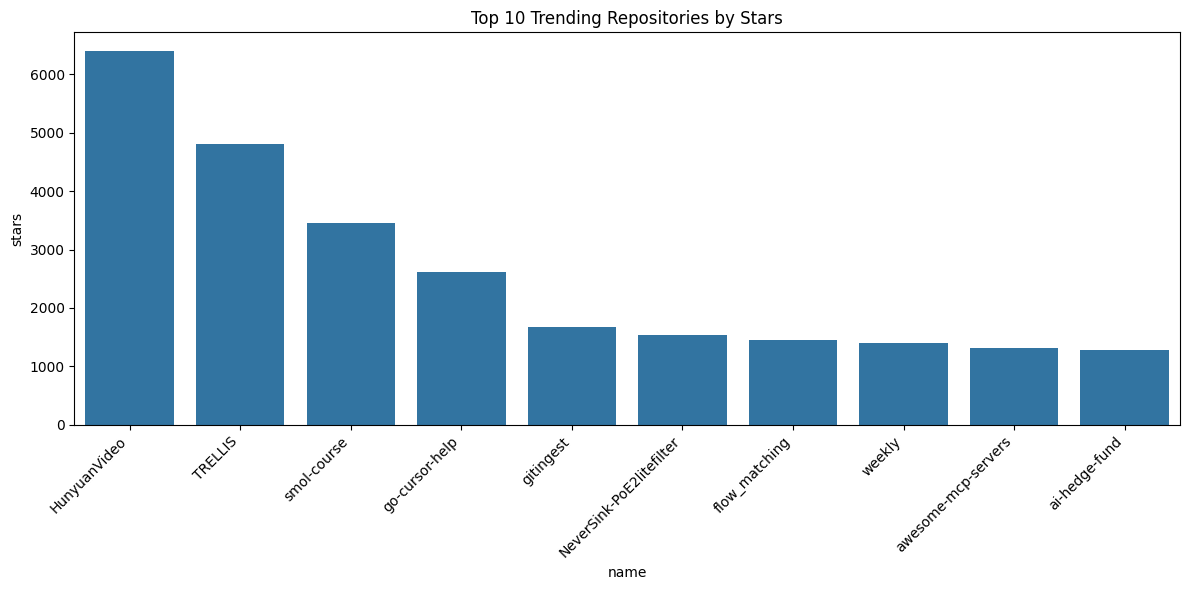

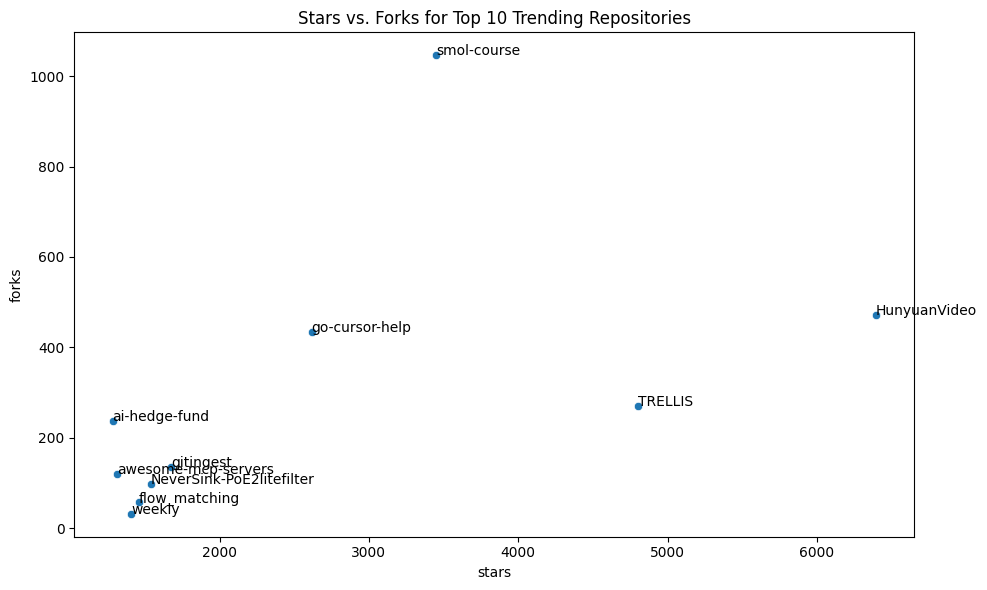

In [6]:
# Create a bar plot of stars for each repository
plt.figure(figsize=(12, 6))
sns.barplot(x="name", y="stars", data=df_repos)
plt.title("Top 10 Trending Repositories by Stars")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Create a scatter plot of stars vs. forks
plt.figure(figsize=(10, 6))
sns.scatterplot(x="stars", y="forks", data=df_repos)
plt.title("Stars vs. Forks for Top 10 Trending Repositories")
for i, row in df_repos.iterrows():
    plt.annotate(row["name"], (row["stars"], row["forks"]))
plt.tight_layout()
plt.show()

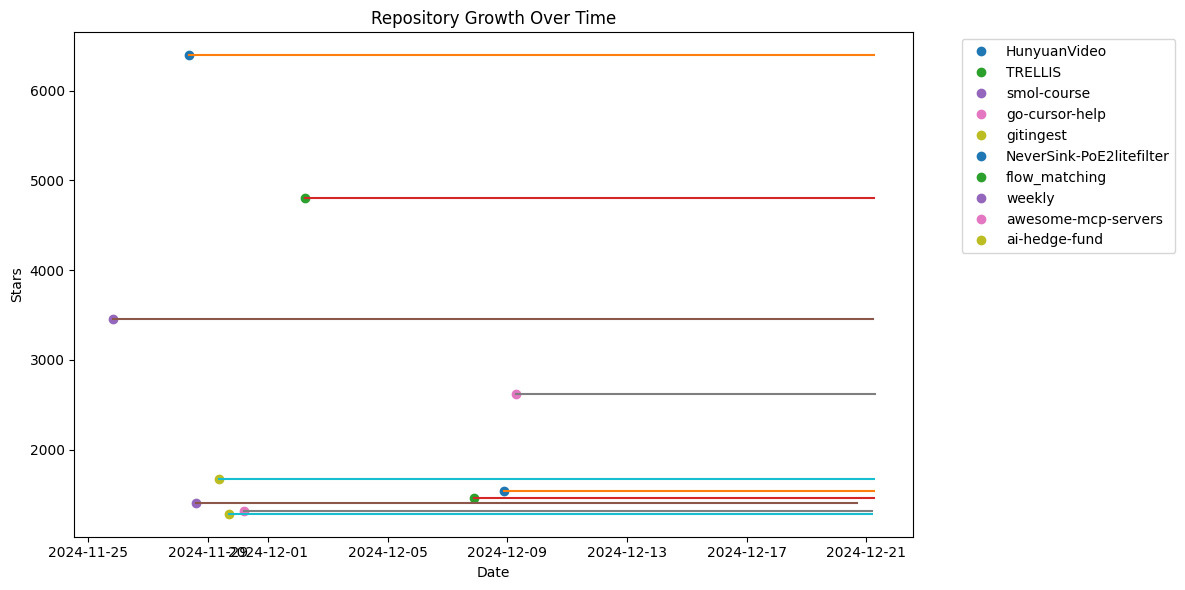

In [7]:
# Convert date columns to datetime
date_columns = ['created_at', 'updated_at', 'latest_commit']
for col in date_columns:
    df_repos[col] = pd.to_datetime(df_repos[col])

# Plot repository growth over time
plt.figure(figsize=(12, 6))
for _, repo in df_repos.iterrows():
    plt.plot(repo['created_at'], repo['stars'], 'o', label=repo['name'])
    plt.plot([repo['created_at'], repo['updated_at']], [repo['stars'], repo['stars']], '-')
plt.xlabel('Date')
plt.ylabel('Stars')
plt.title('Repository Growth Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


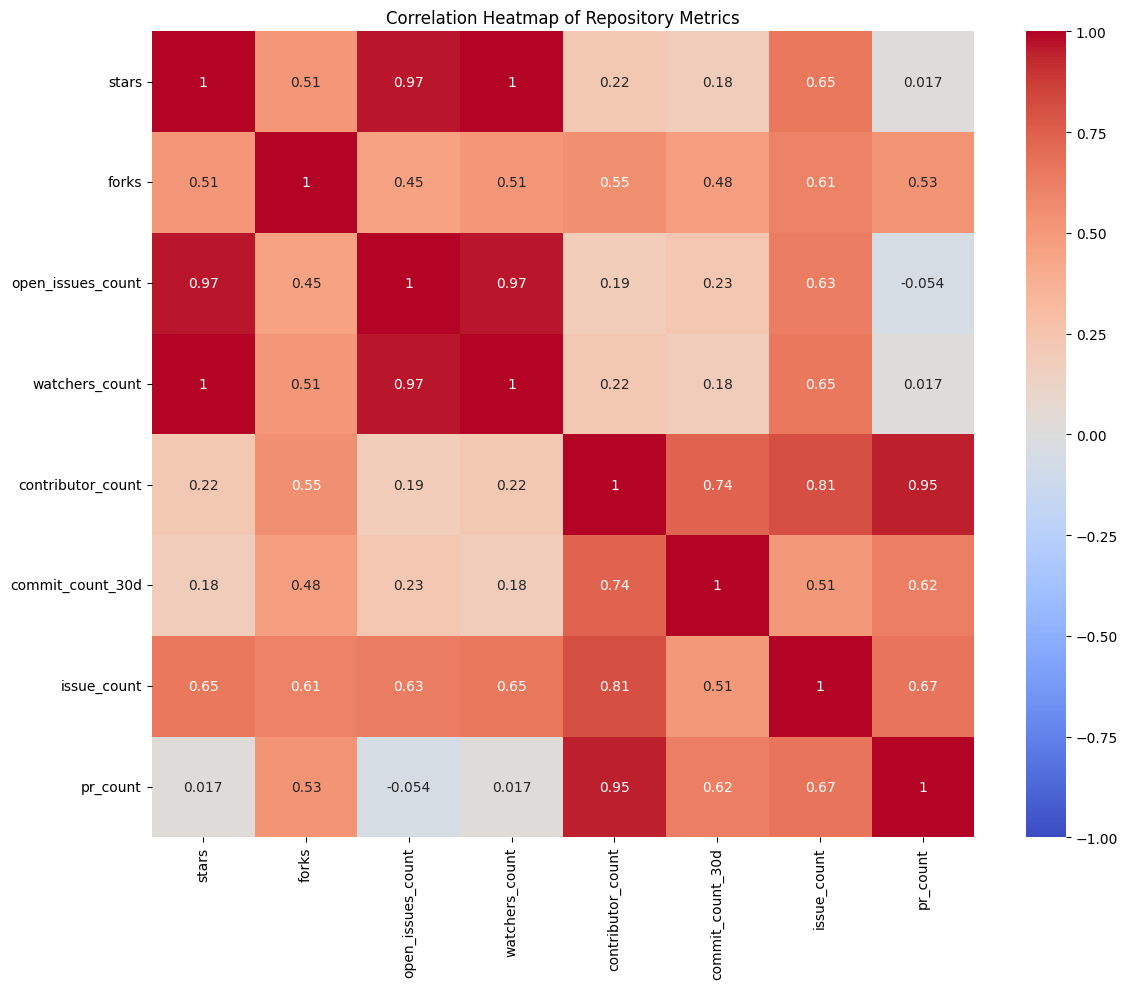

In [8]:
# Calculate correlation matrix
import numpy as np
corr_matrix = df_repos.select_dtypes(include=[np.number]).corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Repository Metrics')
plt.tight_layout()
plt.show()


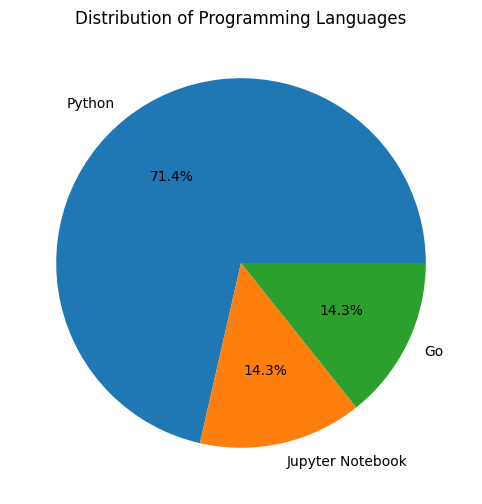

In [9]:
plt.figure(figsize=(10, 6))
df_repos['language'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Programming Languages')
plt.ylabel('')
plt.show()


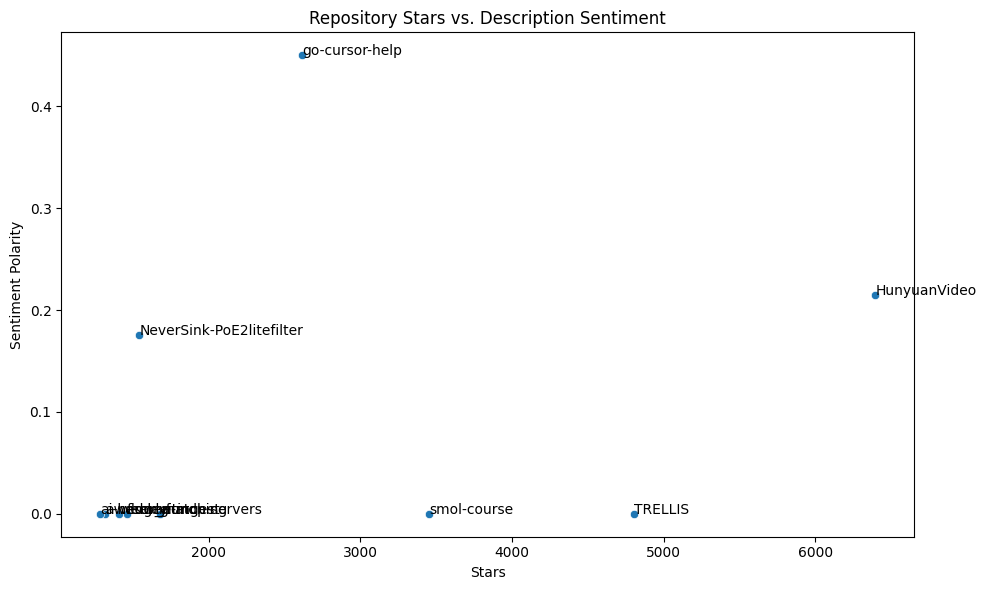

In [10]:
from textblob import TextBlob

df_repos['description_sentiment'] = df_repos['description'].apply(lambda x: TextBlob(x).sentiment.polarity if x else 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='stars', y='description_sentiment', data=df_repos)
plt.title('Repository Stars vs. Description Sentiment')
plt.xlabel('Stars')
plt.ylabel('Sentiment Polarity')
for i, row in df_repos.iterrows():
    plt.annotate(row['name'], (row['stars'], row['description_sentiment']))
plt.tight_layout()
plt.show()


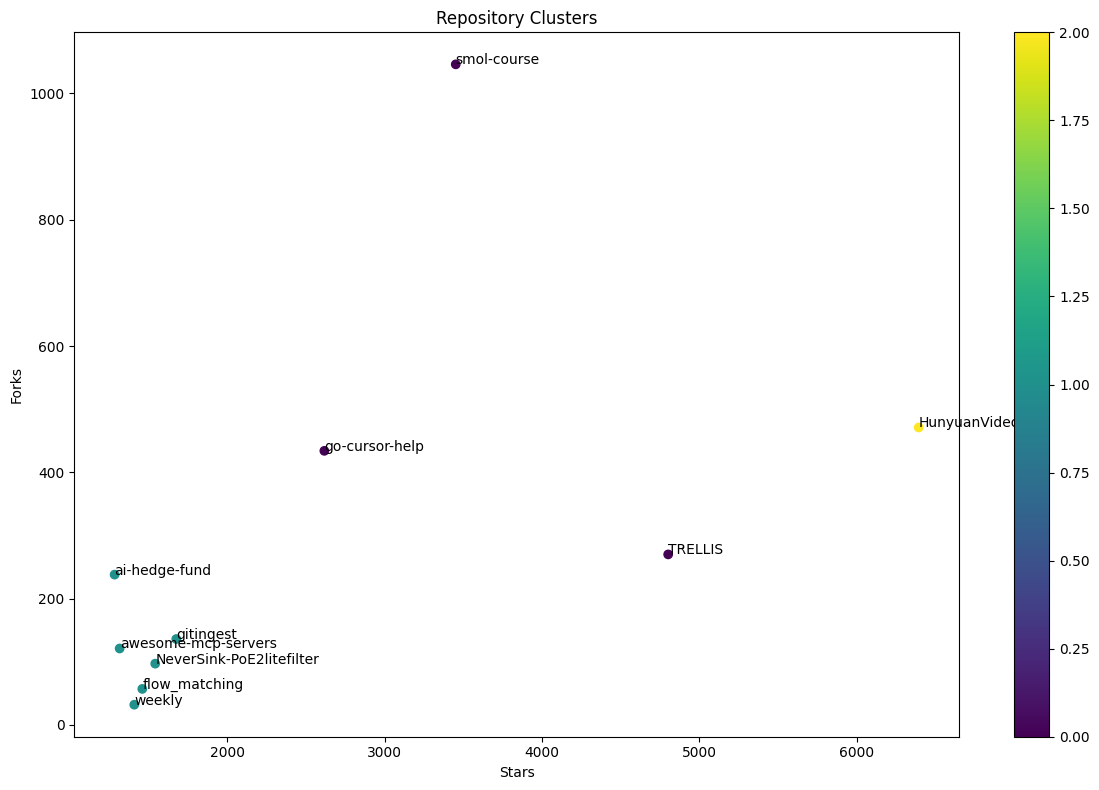

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
features = ['stars', 'forks', 'open_issues_count', 'watchers_count', 'contributor_count', 'commit_count_30d']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_repos[features])

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_repos['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_repos['stars'], df_repos['forks'], c=df_repos['cluster'], cmap='viridis')
plt.xlabel('Stars')
plt.ylabel('Forks')
plt.title('Repository Clusters')
plt.colorbar(scatter)
for i, row in df_repos.iterrows():
    plt.annotate(row['name'], (row['stars'], row['forks']))
plt.tight_layout()
plt.show()


Mean Squared Error: 4.1359030627651384e-24
R-squared Score: 1.0


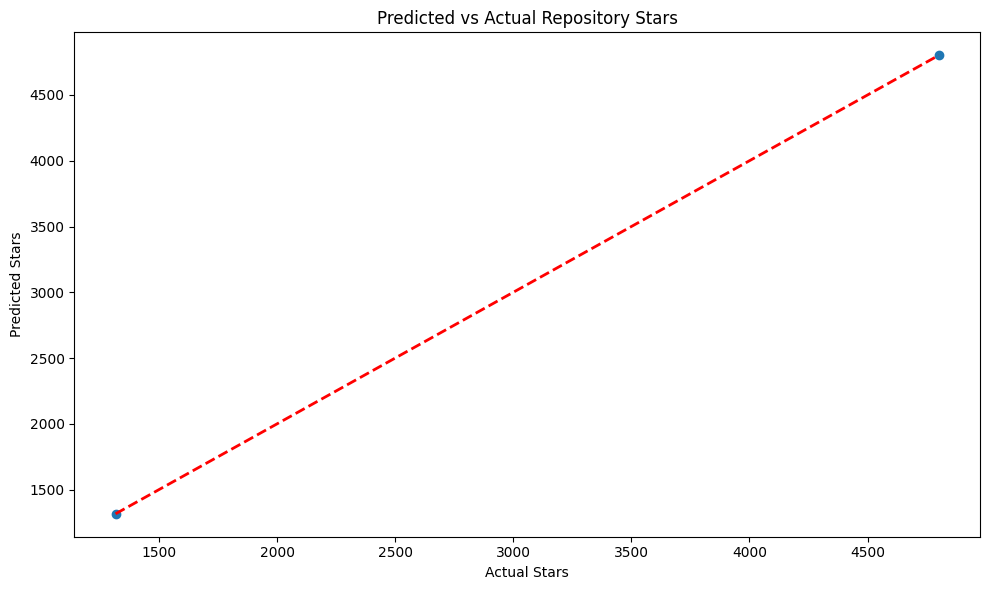

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare features and target
X = df_repos[['forks', 'open_issues_count', 'watchers_count', 'contributor_count', 'commit_count_30d']]
y = df_repos['stars']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stars')
plt.ylabel('Predicted Stars')
plt.title('Predicted vs Actual Repository Stars')
plt.tight_layout()
plt.show()


In [13]:
# Save to CSV
df_repos.to_csv('github_trending_repos.csv', index=False)

# Save to JSON
df_repos.to_json('github_trending_repos.json', orient='records')
